In [1]:
from dataset import TextDataset
import matplotlib.pyplot as plt
import numpy as np
from dataset import EEDataset, TextEEDataset
import pandas as pd
import torch
import torch.nn as nn
from model import TransformerEntityRegressor

c:\Users\Pranav\miniconda3\envs\amazonml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("dataset/split_train.csv")

In [3]:
vc = dict(df['PRODUCT_TYPE_ID'].value_counts())
id_to_ind = {}
default_ind = 0
for k, v in vc.items():
    if v > 10:
        id_to_ind[k] = default_ind
        default_ind += 1
    else:
        id_to_ind[k] = default_ind

In [4]:
train_set = TextEEDataset(path="dataset/split_train.csv", id_to_ind=id_to_ind, default_ind=default_ind)
val_set = TextEEDataset(path="dataset/split_val.csv", id_to_ind=id_to_ind, default_ind=default_ind)

========> LOADING DATASET <========
========> LOADING DATASET <========


<Axes: >

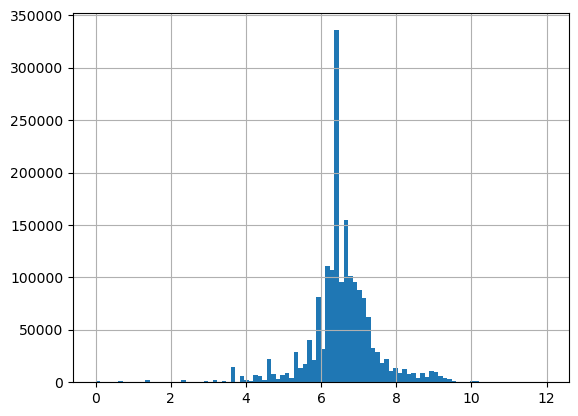

In [5]:
logs = np.log(train_set.data['PRODUCT_LENGTH'])
logs = logs[logs < 12]
mm_scaled = (logs - logs.min()) / (logs.max() - logs.min())
std_scaled = (logs - logs.mean()) / logs.std()
#std_scaled.hist(bins=100)
#mm_scaled.hist(bins=100)
logs.hist(bins=100)

In [6]:
full_train = pd.read_csv("dataset/train.csv")
vc = full_train['PRODUCT_TYPE_ID'].value_counts()
u = vc.index
u

Int64Index([    1, 12064,     0,   123,  6104,  2879,  2986,  2916,    99,
             6548,
            ...
            13311, 11544, 11637, 12005, 13142,  7239, 12536,  4114,  3229,
             4505],
           dtype='int64', length=12907)

In [7]:
from tqdm.auto import tqdm
tqdm.pandas()

In [70]:
preds1 = pd.read_csv("dataset/e2e_t_3895k_preds_snapped.csv")
preds2 = pd.read_csv("dataset/snapped_min.csv")

In [48]:
full_train['PRODUCT_LENGTH'].mean()

4071.839217142947

In [71]:
mins = pd.DataFrame({'len1': preds1['PRODUCT_LENGTH'], 'len2': preds2['PRODUCT_LENGTH']}).min(axis=1)
maxs = pd.DataFrame({'len1': preds1['PRODUCT_LENGTH'], 'len2': preds2['PRODUCT_LENGTH']}).max(axis=1)
mins_df = pd.DataFrame({'PRODUCT_ID': preds1['PRODUCT_ID'], 'PRODUCT_LENGTH': mins})
mins_df.to_csv("dataset/snapped_new3min.csv", index=False)

In [65]:
sub = pd.DataFrame({'sub': mins - 10, '0': 0}).max(axis=1)
sub_df = pd.DataFrame({'PRODUCT_ID': preds1['PRODUCT_ID'], 'PRODUCT_LENGTH': sub})
sub_df.to_csv("dataset/snapped_3min_sub10.csv", index=False)

In [ ]:
closest = [0]*len(mins)
for i, (mn, mx) in enumerate(zip(mins, maxs)):
    if abs(mn - 4071.84) > abs(mx - 700.84):
        closest[i] = mn
    else:
        closest[i] = mx
closest_df = pd.DataFrame({'PRODUCT_ID': preds1['PRODUCT_ID'], 'PRODUCT_LENGTH': closest})
closest_df.to_csv("dataset/mean_farthest_preds.csv", index=False)

In [25]:
(preds1['PRODUCT_LENGTH'] - preds2['PRODUCT_LENGTH'])

0          -15
1        -2380
2          235
3           18
4           13
          ... 
734731     165
734732     -37
734733     -20
734734     147
734735      74
Name: PRODUCT_LENGTH, Length: 734736, dtype: int64

<Axes: >

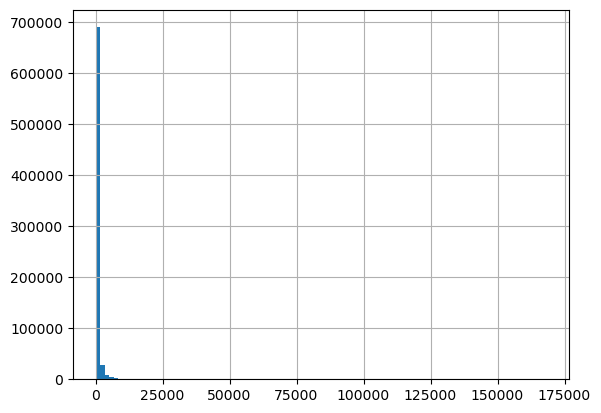

In [17]:
preds2['PRODUCT_LENGTH'].hist(bins=100)

In [31]:
# preds1 = pd.read_csv("dataset/e2e_t_3127k_preds.csv")
# preds2 = pd.read_csv("dataset/e2e_rbd_769k_preds.csv")
comb = pd.DataFrame({'PRODUCT_ID': preds1['PRODUCT_ID']})
comb['PRODUCT_LENGTH'] = preds1['PRODUCT_LENGTH'] * 0.65 + preds2['PRODUCT_LENGTH'] * 0.35
comb.to_csv("dataset/ens_snapped_t_3127k_rbd_769k_preds.csv", index=False)

In [66]:
preds = pd.read_csv("dataset/e2e_t_3895k_preds.csv")
snapped = [0]*len(preds)
for i in tqdm(range(len(preds))):
    min_ind = abs(preds.iloc[i][1] - u).argmin()
    snapped[i] = u[min_ind]

100%|██████████| 734736/734736 [02:24<00:00, 5074.02it/s]


In [67]:
preds['PRODUCT_LENGTH'] = snapped
preds.to_csv("dataset/e2e_t_3895k_preds_snapped.csv", index=False)

In [70]:
preds = pd.read_csv("dataset/e2e_t_400k_preds.csv")
snapped = preds['PRODUCT_LENGTH'].apply(lambda x: u[abs(x - u).argsort()])

 12%|█▏        | 89569/734736 [00:14<01:42, 6266.29it/s]


KeyboardInterrupt: 

In [35]:
logs.min(), logs.max(), logs.mean(), logs.std()

(0.0, 11.997342436644546, 6.551437560975196, 0.9632225819951948)

In [24]:
val_set.data['bullet_ex'] = val_set.data['BULLET_POINTS'].str.extract('(\d+)')
val_set.data

,index,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,bullet_ex
0,0,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495,4
1,1,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574,95
2,2,833712,La Mure / Valbonnais gps,NaN,NaN,1,433.070000,NaN
3,3,1991694,Mediterranean diet for beginners: 7Benefits of...,NaN,NaN,32,600.000000,NaN
4,4,1543564,Kenneth Cole REACTION Men's Crespo Loafer B Sh...,"[Burnished metal center bit,Slightly padded Fo...",NaN,3247,500.000000,NaN
...,...,...,...,...,...,...,...,...
449935,449935,834241,Organ Recital,NaN,NaN,744,475.000000,NaN
449936,449936,2780400,SAVEIT Led LCD TV Cover for Sony Bravia 108 cm...,"[It comes with 2 layer protection. 1st one, be...",SAVEIT Enterprises offer a range of LED/LCD Wa...,1844,300.000000,2
449937,449937,2533034,Casual Flip Flop Slipper Slider for Men (numer...,"[Closure: Slip On,Lifestyle: Casual,Color: White]",Elevate your style with this comfortable pair ...,3249,1181.102361,NaN
449938,449938,1500355,"OTC Medical Posture Brace with Rigid Stays, Sp...",[Tapered and layered front Panel wrap comforta...,NaN,6448,1900.000000,24


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4)

In [6]:
string, type_id, length = next(iter(train_loader))

In [7]:
model = TransformerEntityRegressor(
    transformer="bert-base-uncased",
    embedding_dim=32,
    num_embeddings=id_to_ind.__len__(),
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
model.to("cuda")

TransformerEntityRegressor(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
model(string, type_id, 'cuda')

tensor([[-0.1241],
        [-0.2713],
        [-0.4102],
        [-0.2930]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [13]:
import pandas as pd
test = pd.read_csv('dataset/test.csv')

In [18]:
test_preds = pd.DataFrame({'PRODUCT_ID': test['PRODUCT_ID'], 'PRODUCT_LENGTH': 500})
test_preds.to_csv('dataset/test_preds_500.csv', index=False)

In [24]:
def transformed_mape(y_true, y_pred):
    #y_true = (np.log(y_true) - val_set.mean) / val_set.std
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + 1e-8))

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
from model import EntityEmbedding
model = EntityEmbedding(embedding_dim=32, num_embeddings=len(id_to_ind))
model.load_state_dict(torch.load('checkpoints/transform/epoch_1.pth.tar')['state_dict'])

<All keys matched successfully>

In [89]:
model.eval()
model(torch.tensor([1, 34, 455, 299, 0, 12501]))

tensor([[0.0011],
        [0.0013],
        [0.0016],
        [0.0011],
        [0.0012],
        [0.0015]], grad_fn=<AddmmBackward0>)

In [92]:
mape = 0
total = 0
for i in range(0, len(val_set), 8):
    x = val_set.data["PRODUCT_TYPE_ID"][i:i+8]
    inds = [0]*len(x)
    for j, k in enumerate(x):
        if k in id_to_ind.keys():
            inds[j] = id_to_ind[k]
        else:
            inds[j] = default_ind
    x = torch.tensor(inds)
    out = model(x).squeeze().detach().numpy()
    out = (out * val_set.std) + val_set.mean
    y = val_set.data["PRODUCT_LENGTH"][i:i+8]
    total += len(y)
    #print(x)
    sum = np.sum(np.abs(y - out) / (np.abs(y) + 1e-8))
    mape += sum
 
print(out[:10], y[:10])
print(mape / total)

KeyboardInterrupt: 

In [30]:
transformed_mape(val_set.data['PRODUCT_LENGTH'][:1], 40)

0.946526315722277

In [46]:
df['PRODUCT_LENGTH'].mean(), df['PRODUCT_LENGTH'].std(), df['PRODUCT_LENGTH'].max(), df['PRODUCT_LENGTH'].min()

(4164.737850855155, 1465722.4180191627, 1885801400.0, 1.0)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('dataset/train.csv')
train

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000
...,...,...,...,...,...,...
2249693,2422167,Nike Women's As W Ny Df Swsh Hn Kh Bra (CZ7610...,Material : Polyester,NaN,3009,1181.100000
2249694,2766635,"(3PCS) Goose Game Cute Cartoon Enamel Pins, Fu...",[❤ [Inspiration] Inspired by the Untitled Goos...,<p><b>[Brand]: </b>XVIEONR</p> <p><br></p> <p>...,3413,125.984252
2249695,1987786,Kangroo Sweep Movement Printed Wooden Wall Clo...,"[Dial size: 12 inches in diameter,Big, clear r...",Wall Clocks Are Very Attractive In Looks And E...,1574,1200.000000
2249696,1165754,Electro Voice EKX-BRKT15 | Wall Mount Bracket ...,NaN,NaN,592,2900.000000


In [4]:
np.exp(12)

162754.79141900392

Text(0.5, 1.0, 'Normalized lLog product length distribution')

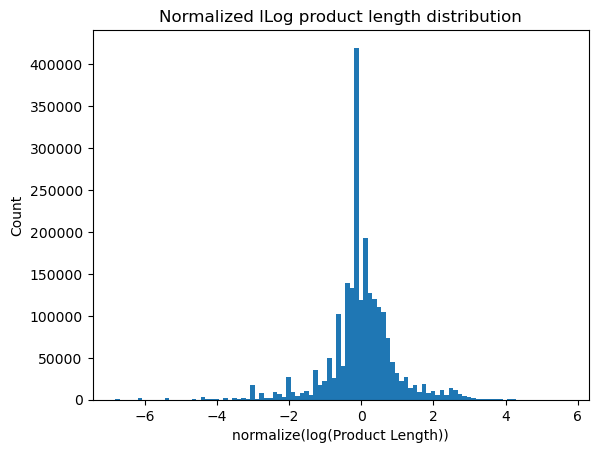

In [15]:
logs = np.log(train['PRODUCT_LENGTH'])
normalized_logs = (logs.loc[logs < 12] - 6.5502) / 0.9601
plt.hist(normalized_logs, bins=100)
plt.xlabel('normalize(log(Product Length))')
plt.ylabel('Count')
plt.title('Normalized lLog product length distribution')

In [16]:
train['PRODUCT_LENGTH'].value_counts()

600.000000     132095
590.551180      80428
500.000000      62388
393.700787      58178
850.000000      45034
                ...  
81.100000           1
6299.212598         1
2831.250000         1
321.652900          1
271.250000          1
Name: PRODUCT_LENGTH, Length: 16655, dtype: int64